##  HIGGS BOSSON FORECASTING

- To keep it basic, according to one of the Big Bang Theories, the entire universe used to be a singular particle before a fuse called the Boson caused it to explode. 
- The `Higgs Boson` are a type of unstable subatomic particle that breaks down very quickly.  Scientist studies the decay of the collision and works backwards. To assist scientist in differentiating the background noise from the signal, some machine learning algorithms using pyspark are modelled to better predict the Higgs Boson.

- This is a `classification problem` to distinguish between a **signal process** which produces Higgs bosons and a **background process** which does not. 

## Dataset
- URL:  http://archive.ics.uci.edu/ml/datasets/HIGGS#
- The data has been produced using Monte Carlo simulations. 

- The first 21 features (columns 2–22) are kinematic properties measured by the particle detectors in the accelerator. 

- The last 7 features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. 

## Attribute Information:

- The `first column` is the class label (1 for signal, 0 for background).
- Followed by the `28 features` (21 low-level(Primitive) features then 7 high-level(Derived) features).

In [ ]:
# Install PySpark and related dependencies
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 30 kB/s 
     |████████████████████████████████| 199 kB 48.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=e4dc97a1cad6a5918f119f277a3237f9d7dd50ce179a20a1968b8808ce458152
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
# Import useful PySpark packages
import pyspark
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, count, explode, concat, desc, explode, lit, split, avg, col, concat, desc, explode,  udf, isnull, min, max ,stddev , isnan
from pyspark.sql.types import StructType,StructField,StringType,DoubleType
import pyspark.sql.functions as func
import functools


from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel,RandomForest, RandomForestModel
from pyspark.ml import Pipeline

from pyspark.ml.feature import StringIndexer, VectorIndexer, StandardScaler, VectorAssembler
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg
from pyspark.ml.linalg import DenseVector

from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator




In [ ]:
import numpy as np
import pandas as pd
import math
import time

import warnings
warnings.filterwarnings("ignore")

#  The following import allows to use Python's plotting APIs: matplotlib and seaborn
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim, xlim
import matplotlib.patches as mpatches

# The following directive is to allow the inline visualization of generated plots
%matplotlib inline

import seaborn as sns
sns.set_theme()
# Setting color palette.
orange_black = ['#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820']
# Setting plot styling.
plt.style.use('ggplot')

import plotly.offline as ply
import plotly.graph_objs as go
from plotly.subplots import make_subplots
ply.init_notebook_mode(connected=True)


**Whenever we work with pyspark we have to create a Spark Context**

In [ ]:
# Create spark session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '8G').set('spark.driver.memory', '8G').set('spark.driver.maxResultSize', '15G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


**Check everything is ok**

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.driver.maxResultSize', '15G'),
 ('spark.app.startTime', '1656445055917'),
 ('spark.executor.memory', '8G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.mem

In [ ]:
# Link Google Colab to our Google Drive
GDRIVE_DIR = "/content/gdrive" # Your own mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive" # Your own home directory
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/HIGGS.csv.gz" # Your own data directory

In [ ]:
# Point Colaboratory to our Google Drive
from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


Here we don't have headers (tag names) added to our dataset, therefore i am adding this cell of code which will attach the headers to dataset while we load dataset and keep the infer schema to false.


*   The struct type creates external structure of our schema 
*   The structfield adds the individual properties for each feature like datatype , legth etc.
* Here we have only double type of features (energy, wavelengths,    amplititudes etc)



In [ ]:
# Create the schema for the dataset
higgsSchema = StructType([
              StructField("label", DoubleType(), True),
              StructField("PRI_lepton pT", DoubleType(), True),
              StructField("PRI_lepton eta", DoubleType(), True),
              StructField("PRI_lepton phi", DoubleType(), True),
              StructField("PRI_missing energy magnitude", DoubleType(), True),
              StructField("PRI_missing energy phi", DoubleType(), True),
              StructField("PRI_jet 1 pt", DoubleType(), True),
              StructField("PRI_jet 1 eta", DoubleType(), True),
              StructField("PRI_jet 1 phi", DoubleType(), True),
              StructField("PRI_jet 1 b-tag", DoubleType(), True),
              StructField("PRI_jet 2 pt", DoubleType(), True),
              StructField("PRI_jet 2 eta", DoubleType(), True),
              StructField("PRI_jet 2 phi", DoubleType(), True),
              StructField("PRI_jet 2 b-tag", DoubleType(), True),
              StructField("PRI_jet 3 pt", DoubleType(), True),
              StructField("PRI_jet 3 eta", DoubleType(), True),
              StructField("PRI_jet 3 phi", DoubleType(), True),
              StructField("PRI_jet 3 b-tag", DoubleType(), True),
              StructField("PRI_jet 4 pt", DoubleType(), True),
              StructField("PRI_jet 4 eta", DoubleType(), True),
              StructField("PRI_jet 4 phi", DoubleType(), True),
              StructField("PRI_jet 4 b-tag", DoubleType(), True),
              # these are the derived features 
              StructField("DRI_m_jj", DoubleType(), True),
              StructField("DRI_m_jjj", DoubleType(), True),
              StructField("DRI_m_lv", DoubleType(), True),
              StructField("DRI_m_jlv", DoubleType(), True),
              StructField("DRI_m_bb", DoubleType(), True),
              StructField("DRI_m_wbb", DoubleType(), True),
              StructField("DRI_m_wwbb", DoubleType(), True),
              ])

### Check the created schema

In [ ]:
higgsSchema

StructType([StructField('label', DoubleType(), True), StructField('PRI_lepton pT', DoubleType(), True), StructField('PRI_lepton eta', DoubleType(), True), StructField('PRI_lepton phi', DoubleType(), True), StructField('PRI_missing energy magnitude', DoubleType(), True), StructField('PRI_missing energy phi', DoubleType(), True), StructField('PRI_jet 1 pt', DoubleType(), True), StructField('PRI_jet 1 eta', DoubleType(), True), StructField('PRI_jet 1 phi', DoubleType(), True), StructField('PRI_jet 1 b-tag', DoubleType(), True), StructField('PRI_jet 2 pt', DoubleType(), True), StructField('PRI_jet 2 eta', DoubleType(), True), StructField('PRI_jet 2 phi', DoubleType(), True), StructField('PRI_jet 2 b-tag', DoubleType(), True), StructField('PRI_jet 3 pt', DoubleType(), True), StructField('PRI_jet 3 eta', DoubleType(), True), StructField('PRI_jet 3 phi', DoubleType(), True), StructField('PRI_jet 3 b-tag', DoubleType(), True), StructField('PRI_jet 4 pt', DoubleType(), True), StructField('PRI_j

In [ ]:
# Create PySpark's DataFrame: Read dataset into a Spark Dataframe from a csv file
higgs_df = spark.read.format("csv").option("header", "false").option("inferSchema", "false").schema(higgsSchema).load(GDRIVE_DATA_DIR)



*   We kept trunacate false to show all the columns of the dataset




In [ ]:
# Display the first n=5 rows of the loaded dataset
higgs_df.show(n=5, truncate=False)

+-----+------------------+-------------------+-------------------+----------------------------+----------------------+------------------+--------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+--------------------+-------------------+-----------------+-------------------+---------------------+---------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|label|PRI_lepton pT     |PRI_lepton eta     |PRI_lepton phi     |PRI_missing energy magnitude|PRI_missing energy phi|PRI_jet 1 pt      |PRI_jet 1 eta       |PRI_jet 1 phi      |PRI_jet 1 b-tag   |PRI_jet 2 pt      |PRI_jet 2 eta      |PRI_jet 2 phi      |PRI_jet 2 b-tag   |PRI_jet 3 pt      |PRI_jet 3 eta       |PRI_jet 3 phi      |PRI_jet 3 b-tag  |PRI_jet 4 pt       |PRI_jet 4 eta        |PRI_jet 4 phi        |PRI_jet 4 b-ta

In [ ]:
# Check the col headers
higgs_df.columns

['label',
 'PRI_lepton pT',
 'PRI_lepton eta',
 'PRI_lepton phi',
 'PRI_missing energy magnitude',
 'PRI_missing energy phi',
 'PRI_jet 1 pt',
 'PRI_jet 1 eta',
 'PRI_jet 1 phi',
 'PRI_jet 1 b-tag',
 'PRI_jet 2 pt',
 'PRI_jet 2 eta',
 'PRI_jet 2 phi',
 'PRI_jet 2 b-tag',
 'PRI_jet 3 pt',
 'PRI_jet 3 eta',
 'PRI_jet 3 phi',
 'PRI_jet 3 b-tag',
 'PRI_jet 4 pt',
 'PRI_jet 4 eta',
 'PRI_jet 4 phi',
 'PRI_jet 4 b-tag',
 'DRI_m_jj',
 'DRI_m_jjj',
 'DRI_m_lv',
 'DRI_m_jlv',
 'DRI_m_bb',
 'DRI_m_wbb',
 'DRI_m_wwbb']

In [ ]:
# Print out the schema of the Dataframe
higgs_df.printSchema()

root
 |-- label: double (nullable = true)
 |-- PRI_lepton pT: double (nullable = true)
 |-- PRI_lepton eta: double (nullable = true)
 |-- PRI_lepton phi: double (nullable = true)
 |-- PRI_missing energy magnitude: double (nullable = true)
 |-- PRI_missing energy phi: double (nullable = true)
 |-- PRI_jet 1 pt: double (nullable = true)
 |-- PRI_jet 1 eta: double (nullable = true)
 |-- PRI_jet 1 phi: double (nullable = true)
 |-- PRI_jet 1 b-tag: double (nullable = true)
 |-- PRI_jet 2 pt: double (nullable = true)
 |-- PRI_jet 2 eta: double (nullable = true)
 |-- PRI_jet 2 phi: double (nullable = true)
 |-- PRI_jet 2 b-tag: double (nullable = true)
 |-- PRI_jet 3 pt: double (nullable = true)
 |-- PRI_jet 3 eta: double (nullable = true)
 |-- PRI_jet 3 phi: double (nullable = true)
 |-- PRI_jet 3 b-tag: double (nullable = true)
 |-- PRI_jet 4 pt: double (nullable = true)
 |-- PRI_jet 4 eta: double (nullable = true)
 |-- PRI_jet 4 phi: double (nullable = true)
 |-- PRI_jet 4 b-tag: double (

In [ ]:
# Check the shape of the dataset, i.e., number of rows and columns
print("The shape of the dataset is {:d} rows by {:d} columns".format(higgs_df.count(), len(higgs_df.columns)))

The shape of the dataset is 11000000 rows by 29 columns


In [ ]:
# Check the data types of features in the loaded dataset
print(higgs_df.dtypes)

[('label', 'double'), ('PRI_lepton pT', 'double'), ('PRI_lepton eta', 'double'), ('PRI_lepton phi', 'double'), ('PRI_missing energy magnitude', 'double'), ('PRI_missing energy phi', 'double'), ('PRI_jet 1 pt', 'double'), ('PRI_jet 1 eta', 'double'), ('PRI_jet 1 phi', 'double'), ('PRI_jet 1 b-tag', 'double'), ('PRI_jet 2 pt', 'double'), ('PRI_jet 2 eta', 'double'), ('PRI_jet 2 phi', 'double'), ('PRI_jet 2 b-tag', 'double'), ('PRI_jet 3 pt', 'double'), ('PRI_jet 3 eta', 'double'), ('PRI_jet 3 phi', 'double'), ('PRI_jet 3 b-tag', 'double'), ('PRI_jet 4 pt', 'double'), ('PRI_jet 4 eta', 'double'), ('PRI_jet 4 phi', 'double'), ('PRI_jet 4 b-tag', 'double'), ('DRI_m_jj', 'double'), ('DRI_m_jjj', 'double'), ('DRI_m_lv', 'double'), ('DRI_m_jlv', 'double'), ('DRI_m_bb', 'double'), ('DRI_m_wbb', 'double'), ('DRI_m_wwbb', 'double')]


# EDA

**Describing the dataset/particular column**
- If we want to have a look at the statistical summary of the dataset/any particular column of a DataFrame, we use the `describe` method. 
- This method gives us the statistical summary of the given column, if not specified it provides the statistical summary of the DataFrame.
- Also counting all the Null values present in our dataset.

In [ ]:
# Let's check the  Statistical summary of the `PRI_lepton pT` column
higgs_df.describe("PRI_lepton pT").show()

+-------+------------------+
|summary|     PRI_lepton pT|
+-------+------------------+
|  count|          11000000|
|   mean|0.9914658435843994|
| stddev|0.5653777011089389|
|    min|0.2746966481208801|
|    max| 12.09891414642334|
+-------+------------------+



In [ ]:
# Counting Null values present in the dataset
def counting_null(df):
    null_count = list()
    for col in df.columns:
        missing_values = df.filter((df[col] == "") \
                                   | df[col].isNull()
                                   | isnan(df[col])).count()
        null_count.append(missing_values)
    return null_count

#  Statistical description of all the features
def sumtable(df):
    summary = df.describe().toPandas().transpose()
    summary = summary.rename(columns=summary.iloc[0]).drop(summary.index[0])
    summary['null_count'] = counting_null(df)
    del df
    
    return summary

This table is giving the statiscal description of the data (like count, mean, stddev ,min , max etc)

* For most of the features mean is between -1 to 1.
* There are some coumns having mean greater than 1 or less than -1 which made me to use the normalization or standard scalar before the application of the models.
* The values of signals are mostly symmetrical.
* Energy value have postive value, which is expected hence gives good hint that data set is properly collected.
* There are no null values that means data is not missing for any column.
* Count for every column enteries is same means there are no NAN values.



In [ ]:
# Show the summary table consisting of statistical dscription
sumtable(higgs_df)

,count,mean,stddev,min,max,null_count
label,11000000,0.5299202727272727,0.49910399710463177,0.0,1.0,0
PRI_lepton pT,11000000,0.9914658435843994,0.5653777011089389,0.2746966481208801,12.09891414642334,0
PRI_lepton eta,11000000,-8.2976178820622E-6,1.0088265271437713,-2.434976100921631,2.4348678588867188,0
PRI_lepton phi,11000000,-1.3272252572679215E-5,1.00634632962945,-1.7425082921981812,1.7432359457015991,0
PRI_missing energy magnitude,11000000,0.9985363574312471,0.6000184917288308,2.3700884776189923E-4,15.396821022033691,0
PRI_missing energy phi,11000000,2.6134592495411797E-5,1.0063262097577204,-1.7439435720443726,1.7432570457458496,0
PRI_jet 1 pt,11000000,0.9909152318068567,0.4749747474819592,0.13750243186950684,9.940390586853027,0
PRI_jet 1 eta,11000000,-2.0275203997251415E-5,1.0093029987302125,-2.9697251319885254,2.9696741104125977,0
PRI_jet 1 phi,11000000,7.71619920710906E-6,1.0059011335109083,-1.7412374019622803,1.741453766822815,0
PRI_jet 1 b-tag,11000000,0.9999687478206591,1.027807574418606,0.0,2.1730761528015137,0


#### The number of the postive samples and the negative samples is almost equal which suggests the dataset is balanced and doesn't required any data balancing

In [ ]:
# Count target label 
higgs_df.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|5170877|
|  1.0|5829123|
+-----+-------+



Here we are creating a sample dataset with lesser number of rows for the data exploration.

*   We took smaller dataset mainly because of the limited memory avaliablity  of the colab.
*   In order to get the dataset with all of the properties we have sampled it randomly rather than sequentially.



In [ ]:
# Take a sample of dataset
# short_df = higgs_df.sample(withReplacement=False, fraction=0.1, seed=3)

# pd_df = short_df.toPandas()

In [ ]:

# # Create a pandas df for analysis
# func.rand()

# df = higgs_df.orderBy(func.rand()).take(1000000)

# col = higgs_df.columns

# df_panda =pd.DataFrame(df,columns=col)

In [ ]:
# df_panda.to_csv(GDRIVE_HOME_DIR+"/datasets/higgs_short.csv",index=False)

The randomly sampled dataset is intially saved for first run and then in every other run we are loading it from the drive to save the execution time out.

In [ ]:
#Load the subset of our data for analysis
pd_df = pd.read_csv('/content/gdrive/MyDrive/datasets/higgs_short.csv')

print(pd.Series({"Memory usage": "{:.2f} MB".format(pd_df.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(pd_df.shape)}).to_string())

print(" ")
pd_df.head()

Memory usage         221.25 MB
Dataset shape    (1000000, 29)
 


,label,PRI_lepton pT,PRI_lepton eta,PRI_lepton phi,PRI_missing energy magnitude,PRI_missing energy phi,PRI_jet 1 pt,PRI_jet 1 eta,PRI_jet 1 phi,PRI_jet 1 b-tag,...,PRI_jet 4 eta,PRI_jet 4 phi,PRI_jet 4 b-tag,DRI_m_jj,DRI_m_jjj,DRI_m_lv,DRI_m_jlv,DRI_m_bb,DRI_m_wbb,DRI_m_wwbb
0,0.0,3.627606,-0.836693,1.485226,0.810780,1.095899,1.123288,-1.635885,-1.299955,0.000000,...,-0.745005,0.930981,3.101961,2.320591,1.866199,0.983743,2.845105,2.375512,2.018816,1.915726
1,1.0,0.493576,-0.800656,-0.263245,1.979045,0.377471,1.462967,0.092066,-1.216798,0.000000,...,0.329337,0.979813,0.000000,0.998815,0.905501,0.993467,1.053456,0.879685,0.806681,0.781492
2,0.0,0.875699,-1.078238,-0.008564,1.113233,0.428983,1.086736,-1.133839,-1.005027,2.173076,...,-0.218660,1.240067,0.000000,0.733592,0.796941,0.987950,0.900425,1.469999,1.031240,0.816372
3,0.0,1.435157,0.857038,-0.511268,0.378439,0.767363,0.508237,-1.247715,1.222558,0.000000,...,-0.085409,1.518633,3.101961,0.867511,0.941291,0.986889,0.710561,0.528177,0.566748,0.740400
4,0.0,0.498334,0.472321,1.188929,1.137472,-1.451617,0.585279,0.250503,0.017347,0.000000,...,0.685786,0.919328,0.000000,0.662295,0.854446,0.986471,0.511793,1.175304,0.939043,0.812291


# Univariate Analysis*
- Target variable
- Predictor variables



**1) Target variable:** The target Label is a binary variable, taking values 1 and 0, indicating the status of an event.
- 0 ↦ background event
- 1 ↦ signal event

This code snipet is generalized visualization function which will be called by different bar plots to visualize the sum on tips of bars.

In [ ]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

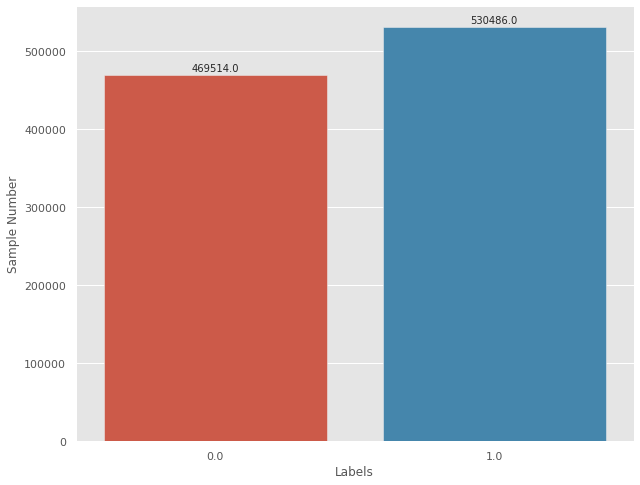

In [ ]:
data =pd.DataFrame( pd_df['label'].value_counts())
data =data.reset_index()
fig,ax =plt.subplots(figsize=(10,8))
ax = sns.barplot(x='index', y='label', data=data)
plt.xlabel("Labels")
plt.ylabel("Sample Number")
show_values(ax)

- The data set is quite well balanced. Of the 1000000 rows, `52.94%` are signals and `47.06%` are background.

**2) Predictor variables**

**# Splitting the dataset by target class**

In [ ]:
data_neg = pd_df[pd_df['label'] == 0.0] # Background events in the dataset
data_pos = pd_df[pd_df['label'] == 1.0] # Signal events in the dataset set

**# Number of unique values for the predictor variables**

Here as we can see the number of uniques values for the positive samples and negatives is almost equal ,this is very much expected for the signals values as most of times these are way properties which have limited spectrum.


*   The Four columns are custom tagged valued having three different types of tags for each.
*   Energy of signal have many unique values signifies the dataset is widely distributed on energy levels of signals.



In [ ]:
df_unique = pd.DataFrame()
df_unique['columnLabel'] = [col for col in pd_df.columns]
df_unique['Dataset  (background events)'] = [data_neg[col].nunique() for col in pd_df.columns]
df_unique['Dataset (signal events)'] = [data_pos[col].nunique() for col in pd_df.columns]
df_unique['Dataset (all events)'] = [pd_df[col].nunique() for col in pd_df.columns]

df_unique.style.set_caption("Number of unique values for the predictor variables")

,columnLabel,Dataset (background events),Dataset (signal events),Dataset (all events)
0,label,1,1,2
1,PRI_lepton pT,19135,15764,19808
2,PRI_lepton eta,4997,4998,5001
3,PRI_lepton phi,6284,6284,6284
4,PRI_missing energy magnitude,366954,400529,616408
5,PRI_missing energy phi,368706,407208,637275
6,PRI_jet 1 pt,28708,31260,34133
7,PRI_jet 1 eta,5989,5997,5999
8,PRI_jet 1 phi,6284,6284,6284
9,PRI_jet 1 b-tag,3,3,3


**# Scatter PLot**

Here we are showing the range of  values for each label for each  feature.


*   For all eta and phi signals the range for positive and negative values (where they take values ) is almost same.
*   For energy missing the range of values is shorter for negative samples compared to postive ones thus may act as good discriminating feature for classification
* The similar values can be interpreted from the graph for the other values and thus we can discuss the discriminatory nature of different features.



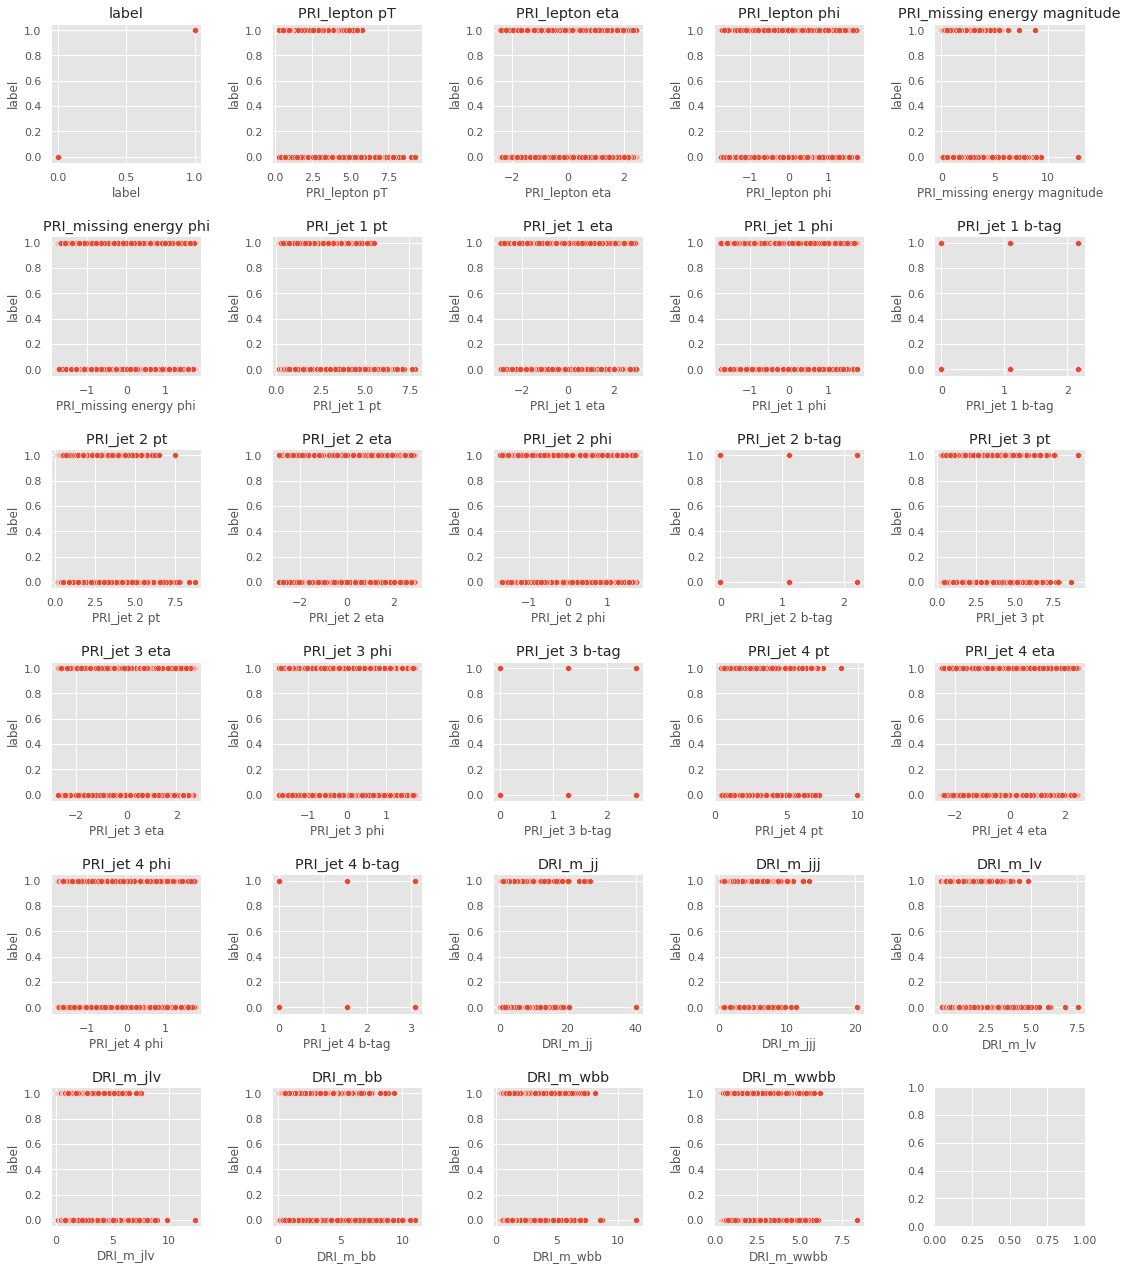

In [ ]:
fig, ax = plt.subplots(6,5, figsize=(16, 18))
ax = ax.flatten()
for i,x in zip(range(29),pd_df.columns):
    sns.scatterplot(pd_df[x], pd_df['label'],  ax=ax[i])
    ax[i].set_title(x)
fig.tight_layout(pad=2.0)  


**# Distributions of the features**

### Discussion about the features

1) In the low-level features `PRI_XXX` we can see a few different patterns emerging.

- Each of the `b-tag` features appear to have 3 possible values: the minimum (0), the maximum (+/- 2.2, +/- 2.5 or +/- 3.1) and roughly the middle between minimum and maximum.

- `eta` feature have a **normal distribution** centered around 0 with min and max around -3 and 3.

- `phi` features have similar minimum (-1.7) and max (1.7) values with a uniform distribution of measurements in between.

- `pt` features follow a Fisher (F) distribution with values ranging from 0 to 7.

2) None of the high-level features `DRI_xxx` follow a normal distribution.

3) The ranges of possible values for the different features do not match, so we must apply feature scaling. There are 2 frequently used strategies: **Normalization** and **Standardization**.

- *Normalization* will rescale a feature to values between 0 and 1.
- *Standardization* will rescales the feature in such a way that the mean becomes 0 with a standard deviation of 1.
- We'll use standardization at the modelling.

4) The `pt` low-level features and high-level features are **skewed**. A PowerTransformer will be applied to bring them closer to a normal distribution.

5) The `phi` features follow a uniform distribution, which means that it likely doesn't contain much information to distinguish between signal and background events. For this reason these features will be **removed**.

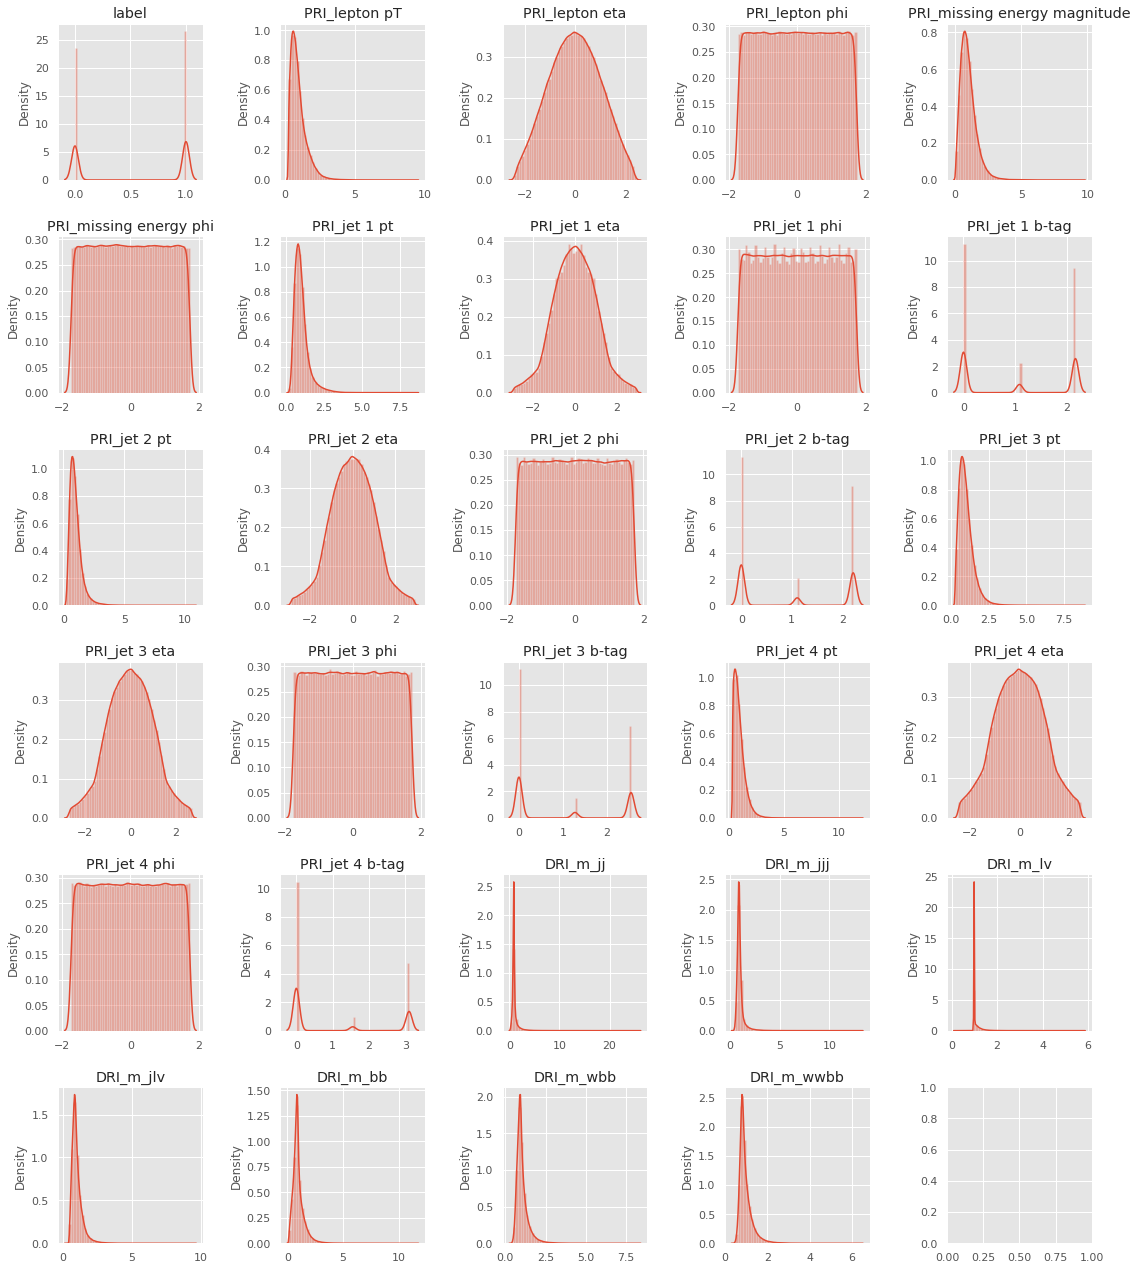

In [ ]:
fig, ax = plt.subplots(6,5, figsize=(16, 18))
ax = ax.flatten()
for i in range(29):
    sns.distplot(pd_df.iloc[:,i].values, ax=ax[i])
    ax[i].set_title(pd_df.columns[i])
fig.tight_layout(pad=2.0)  

**# Box plot of features**


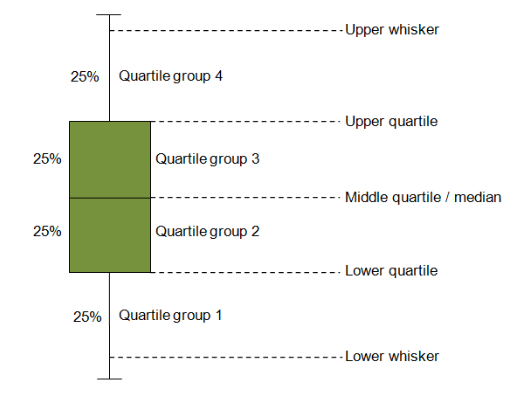

As we can see there are some outliers almost on 9 features of data.
We have removed those outliers as depicted in next box plots shown in plot below.

21 7


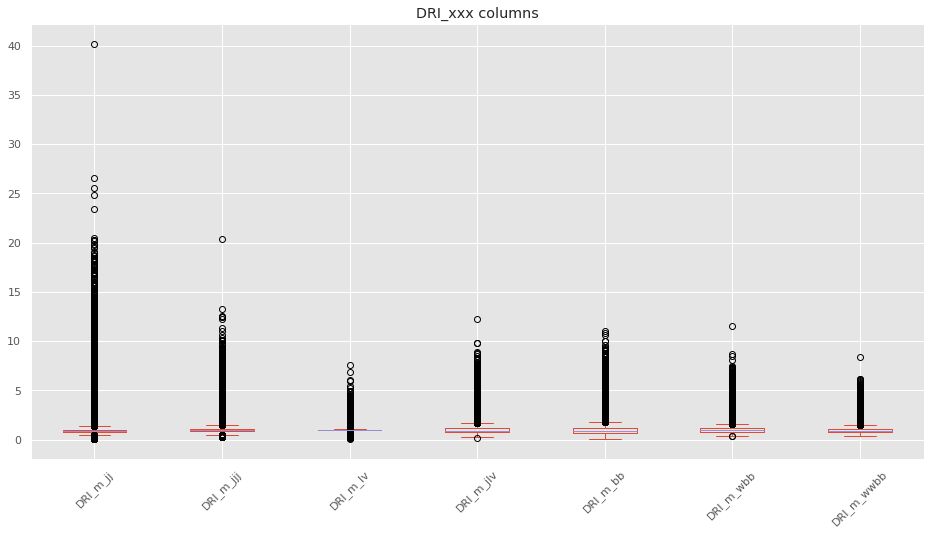

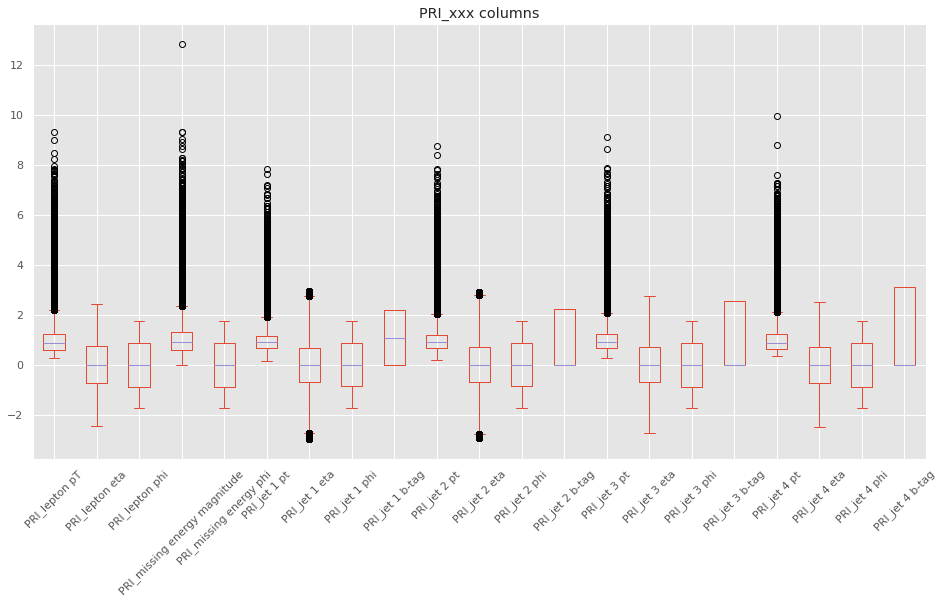

In [ ]:
# separate columns for further analysis
cols_der = [col for col in pd_df.columns if col.startswith('DRI')]
cols_pri = [col for col in pd_df.columns if col.startswith('PRI')]

print(len(cols_pri),len(cols_der))

# plot only DERIVED columns
pd_df[cols_der].plot(kind='box', figsize=(16, 8))
plt.xticks(rotation=45);
plt.title('DRI_xxx columns')
plt.show()

# plot only PRI columns
pd_df[cols_pri].plot(kind='box', figsize=(16, 8))
plt.xticks(rotation=45);
plt.title('PRI_xxx columns')
plt.show()

**# Handling Outliers**

In [ ]:
indexList=[]
for x in pd_df.columns:
  index = pd_df[pd_df[x] > pd_df[x].quantile(.9999)].index
  indexList.extend(list(index))
indexList = (set(indexList))
pd_dff = pd_df.drop(indexList)

21 7


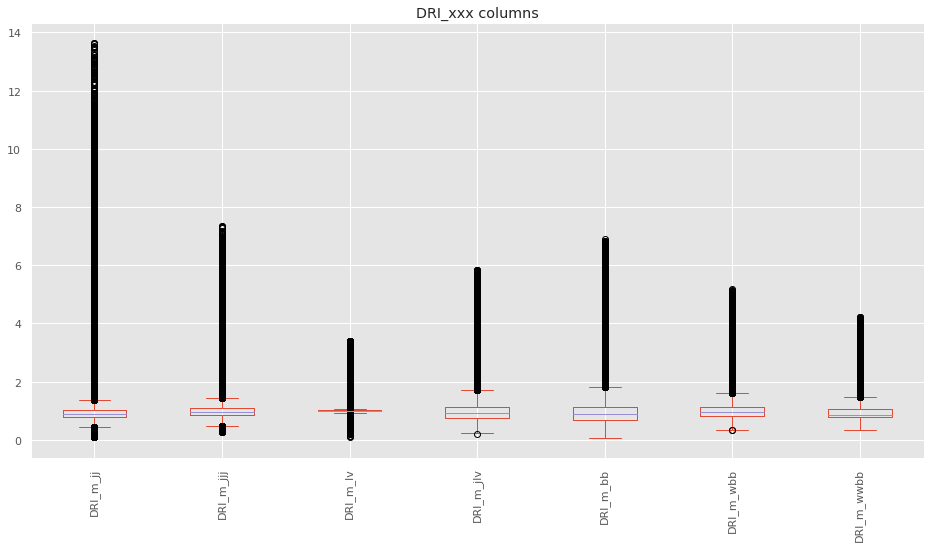

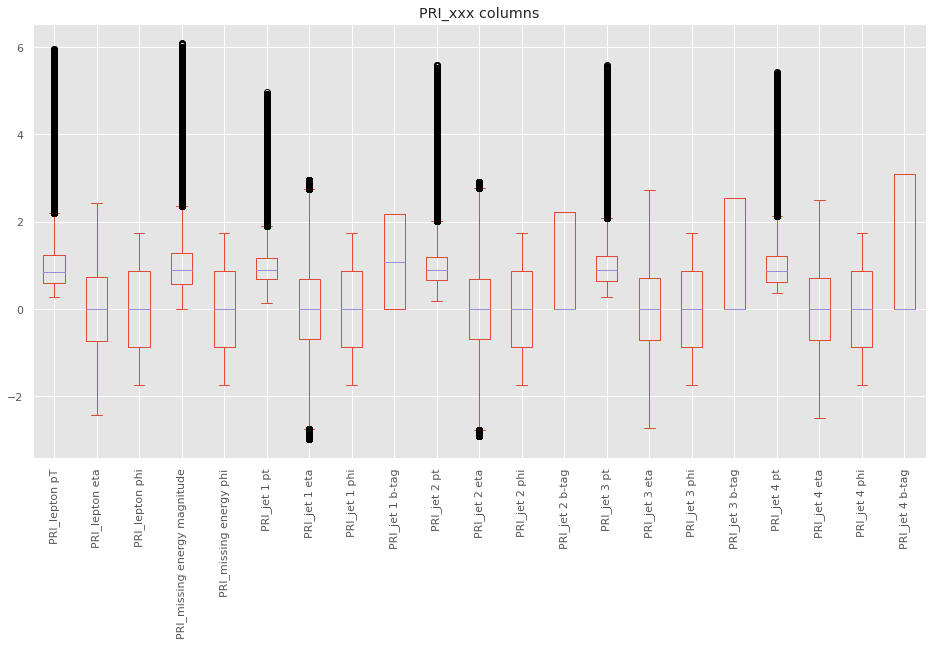

In [ ]:
cols_der = [col for col in pd_dff.columns if col.startswith('DRI')]
cols_pri = [col for col in pd_dff.columns if col.startswith('PRI')]

print(len(cols_pri),len(cols_der))

# plot only DERIVED columns
pd_dff[cols_der].plot(kind='box', figsize=(16, 8))
plt.xticks(rotation=90);
plt.title('DRI_xxx columns')
plt.show()

# plot only PRI columns
pd_dff[cols_pri].plot(kind='box', figsize=(16, 8))
plt.xticks(rotation=90);
plt.title('PRI_xxx columns')
plt.show()

**# Let's have a look on 'PRI_Jet_xx' type of columns**

- NO outlier

In [ ]:
# x_train[cols_pri].columns
cols_jet = ["PRI_jet 1 pt","PRI_jet 1 eta","PRI_jet 1 phi","PRI_jet 1 b-tag",
            "PRI_jet 2 pt",'PRI_jet 2 eta',"PRI_jet 2 phi","PRI_jet 2 b-tag",
            "PRI_jet 3 pt","PRI_jet 3 eta","PRI_jet 3 phi","PRI_jet 3 b-tag",
            "PRI_jet 4 pt","PRI_jet 4 eta","PRI_jet 4 phi","PRI_jet 4 b-tag"]

for col in cols_jet:
    print(pd_df[col].value_counts())

0.703727    146
0.806418    143
0.858726    142
0.985144    138
0.780860    137
           ... 
3.609416      1
3.243445      1
3.201947      1
3.553536      1
2.894513      1
Name: PRI_jet 1 pt, Length: 34133, dtype: int64
-0.247583    606
 0.049486    599
-0.345616    592
 0.151480    588
-0.049537    582
            ... 
 2.893426      3
-2.953882      3
 2.864710      3
 2.853817      2
 2.794403      2
Name: PRI_jet 1 eta, Length: 5999, dtype: int64
-1.354283    304
-1.187416    299
-1.741237    292
 1.299617    292
-0.470052    291
            ... 
 0.001270     85
 1.105585     83
-0.606431     77
-0.219474     76
 0.000161     55
Name: PRI_jet 1 phi, Length: 6284, dtype: int64
0.000000    490249
2.173076    411145
1.086538     98606
Name: PRI_jet 1 b-tag, dtype: int64
0.858662    186
0.764612    175
0.684915    175
0.769648    173
0.720546    173
           ... 
4.797427      1
4.121703      1
3.299427      1
3.755701      1
3.065750      1
Name: PRI_jet 2 pt, Length: 26929, dt

# Features correlations with target variable

**# Get the correlation**

In [ ]:
corr = pd_df.corr()

In [ ]:
corr*100

,label,PRI_lepton pT,PRI_lepton eta,PRI_lepton phi,PRI_missing energy magnitude,PRI_missing energy phi,PRI_jet 1 pt,PRI_jet 1 eta,PRI_jet 1 phi,PRI_jet 1 b-tag,...,PRI_jet 4 eta,PRI_jet 4 phi,PRI_jet 4 b-tag,DRI_m_jj,DRI_m_jjj,DRI_m_lv,DRI_m_jlv,DRI_m_bb,DRI_m_wbb,DRI_m_wwbb
label,100.000000,-4.943049,0.019021,0.068988,-9.988313,0.031510,5.777359,-0.108982,0.011241,-0.848077,...,-0.208411,-0.173453,1.389552,1.343888,2.581858,0.964844,-3.066132,-15.223357,-6.486985,-12.293937
PRI_lepton pT,-4.943049,100.000000,-0.068344,0.050016,-13.963662,-0.103423,16.547108,-0.018791,-0.037632,-0.679891,...,0.130825,0.092932,0.334796,2.647232,1.762622,27.358928,12.973289,0.657812,9.414108,14.053898
PRI_lepton eta,0.019021,-0.068344,100.000000,-0.028130,-0.025387,-0.041133,-0.008502,26.478565,-0.024089,0.125668,...,17.732395,0.003560,-0.120491,-0.053854,-0.031399,-0.028569,-0.000394,0.045362,-0.018200,0.029845
PRI_lepton phi,0.068988,0.050016,-0.028130,100.000000,-0.079902,-4.348653,-0.043215,-0.066199,-16.866895,-0.097318,...,-0.073625,-6.558339,-0.059170,0.056257,0.044448,-0.042918,-0.105786,-0.169666,-0.088330,-0.091443
PRI_missing energy magnitude,-9.988313,-13.963662,-0.025387,-0.079902,100.000000,-0.127901,19.750673,-0.087006,0.057916,-2.940993,...,0.007206,0.143811,0.989647,3.222335,3.075256,17.180333,28.016167,2.666573,21.248259,29.696726
PRI_missing energy phi,0.031510,-0.103423,-0.041133,-4.348653,-0.127901,100.000000,0.133281,-0.113541,-15.443596,0.010984,...,0.083710,-3.811712,-0.061479,0.047077,0.095209,0.030500,-0.034030,0.112462,0.092151,0.102750
PRI_jet 1 pt,5.777359,16.547108,-0.008502,-0.043215,19.750673,0.133281,100.000000,0.057264,-0.058913,-1.602501,...,0.024915,0.200068,-0.453754,18.748451,26.154045,2.088172,27.676829,33.489637,48.117216,45.142123
PRI_jet 1 eta,-0.108982,-0.018791,26.478565,-0.066199,-0.087006,-0.113541,0.057264,100.000000,0.024121,0.016309,...,19.156139,-0.126725,0.046286,0.257377,0.298948,-0.025986,0.029021,0.207307,0.212617,0.143245
PRI_jet 1 phi,0.011241,-0.037632,-0.024089,-16.866895,0.057916,-15.443596,-0.058913,0.024121,100.000000,-0.151825,...,0.128502,-10.084093,0.065751,-0.022502,-0.008075,-0.121741,-0.077824,-0.007329,0.007715,0.055777
PRI_jet 1 b-tag,-0.848077,-0.679891,0.125668,-0.097318,-2.940993,0.010984,-1.602501,0.016309,-0.151825,100.000000,...,0.171120,-0.036471,-23.282183,-11.618003,-7.119062,-0.095894,13.108820,26.908096,11.035224,0.293579


**# PLot the correlation heatmap**

As we can see all of the columns are independent of each and showing very small or zero correlation except the four columns where the correlation is as high as 80 and 90 respectively for two pairs of four columns.

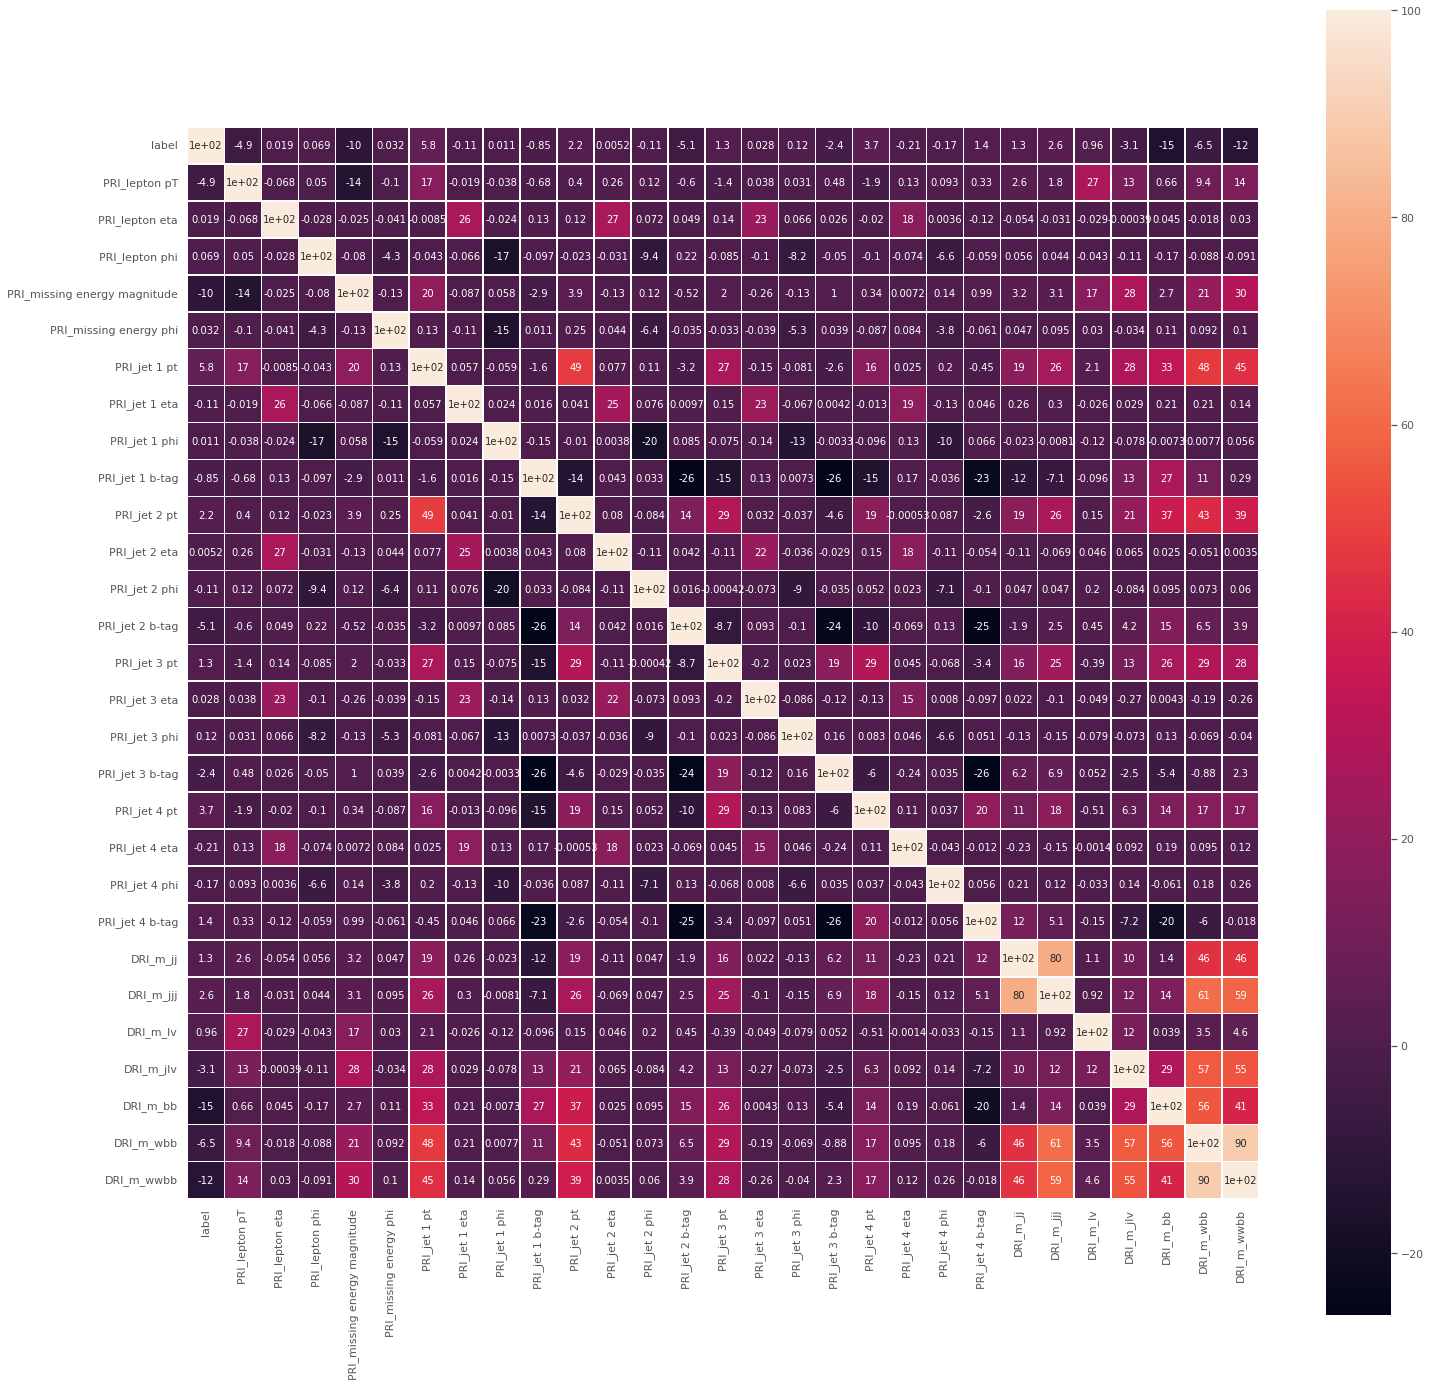

In [ ]:
plt.rcParams["figure.figsize"] = (24,24)
sns.heatmap((corr*100), xticklabels=corr.columns, yticklabels=corr.columns,annot=True, square=True,linewidths=.5 )

**# Correlation bar plot between all features and target feature**

### Showing the unstacked version of correlation for each feature to increase the readability or visualization.

In [ ]:
data = corr.abs().unstack()['label'].reset_index()

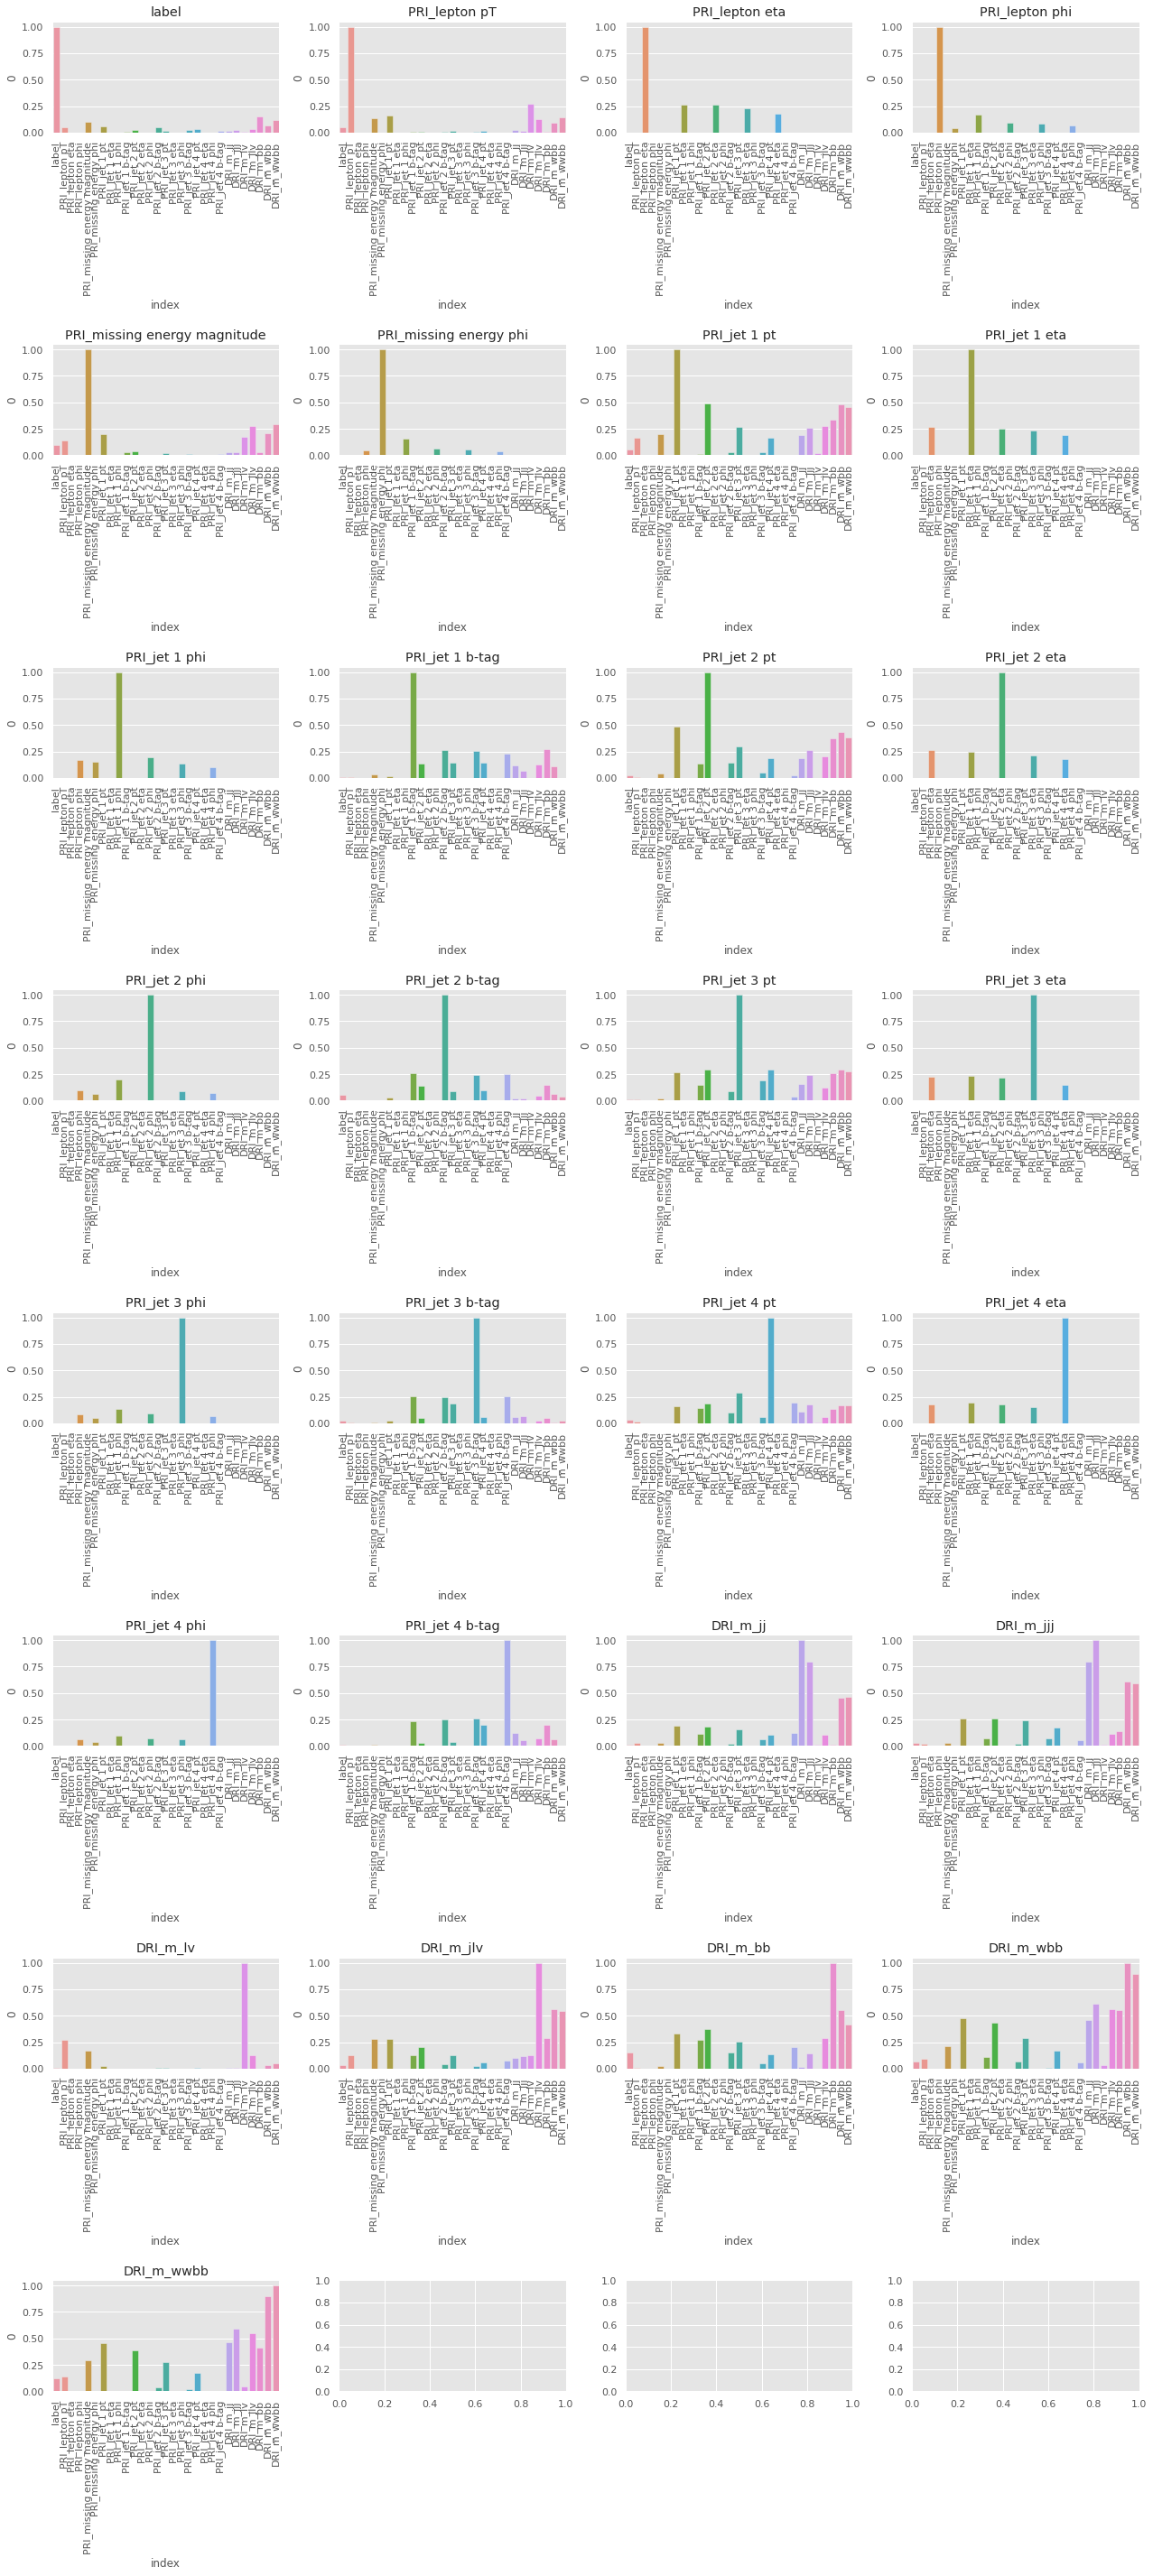

In [ ]:
fig, ax = plt.subplots(8,4, figsize=(18,40))
ax = ax.flatten()
for i,x in zip(range(29),pd_df.columns):
    data = corr.abs().unstack()[x].reset_index()
    sns.barplot(x = 'index', y = 0, data = data , ax=ax[i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = 90)
    ax[i].set_title(x)
fig.tight_layout(pad=2.0)  

# ML Models


In [ ]:
# We start by utilizing a sub sample of the full dataset to test our pyspark models 
data_location = '/content/gdrive/MyDrive/datasets/higgs_short.csv'

#read dataset from gdrive
short_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(data_location)

**Vectorize features**
- So that we can combines a given list of columns into a single vector.

In [ ]:
cols = ['label','PRI_lepton pT','PRI_lepton eta','PRI_lepton phi','PRI_missing energy magnitude',
        'PRI_missing energy phi','PRI_jet 1 pt','PRI_jet 1 eta','PRI_jet 1 phi','PRI_jet 1 b-tag',
        'PRI_jet 2 pt','PRI_jet 2 eta','PRI_jet 2 phi','PRI_jet 2 b-tag','PRI_jet 3 pt','PRI_jet 3 eta',
        'PRI_jet 3 phi','PRI_jet 3 b-tag','PRI_jet 4 pt','PRI_jet 4 eta','PRI_jet 4 phi',   
        'PRI_jet 4 b-tag','DRI_m_jj','DRI_m_jjj','DRI_m_lv','DRI_m_jlv','DRI_m_bb','DRI_m_wbb','DRI_m_wwbb']
assembler = VectorAssembler(inputCols=cols, outputCol="vectFeatures")
data = assembler.transform(short_df)

**Standardize/Scale Features**
- So that we can change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values
- Standardize features by removing the mean and scaling to unit variance

- The standard score of a sample x is calculated as:

                   z = (x - u) / s

- where `u` is the mean of the training samples or zero if `with_mean=False`, and `s` is the standard deviation of the training samples or one if `with_std=False`.

In [ ]:
scaler = StandardScaler(inputCol="vectFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data) #data= scaled features-> spark df

#Train/Test Split 

In [ ]:
(trainData, testData) = data.randomSplit([0.8, 0.2],50)

In [ ]:
print("Records for training: " + str(trainData.count()))
print("Records for evaluation: " + str(testData.count()))

Records for training: 800197
Records for evaluation: 199803


**Comparison of feature distributions for the training set and the test set**
- First we check the distributions of the features for the training set and the test set.
- If we are to train our model on one set (the training set) and use it to make predictions on another (the test set), then it is desirable that the distributions corresponding to the two sets have similar structure.

In [ ]:
data_train_copy = (trainData.toPandas()).copy(deep=True)
data_train_copy['dataset'] = "Train"
data_test_copy = (testData.toPandas()).copy(deep=True)
data_test_copy['dataset'] = "Test"
datashow = pd.concat([data_train_copy,data_test_copy] ,axis = 0, ignore_index =True ) 

In [ ]:
# Function to plot distributions of the float features
def hist(df, cols, bins, ncols = 3):
    nrows = math.ceil(len(cols) / ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 4.2 * nrows), sharey = False)
    for i in range(len(cols)):
        sns.histplot(data = df, x = cols[i], bins = bins, hue = 'dataset', palette = ['red', 'grey'], ax = ax[i // ncols, i % ncols])
        ax[i // ncols, i % ncols].set_xlabel(cols[i])
        if i % ncols != 0:
            ax[i // ncols, i % ncols].set_ylabel(" ")
    plt.tight_layout()
    plt.show()

ValueError: ignored

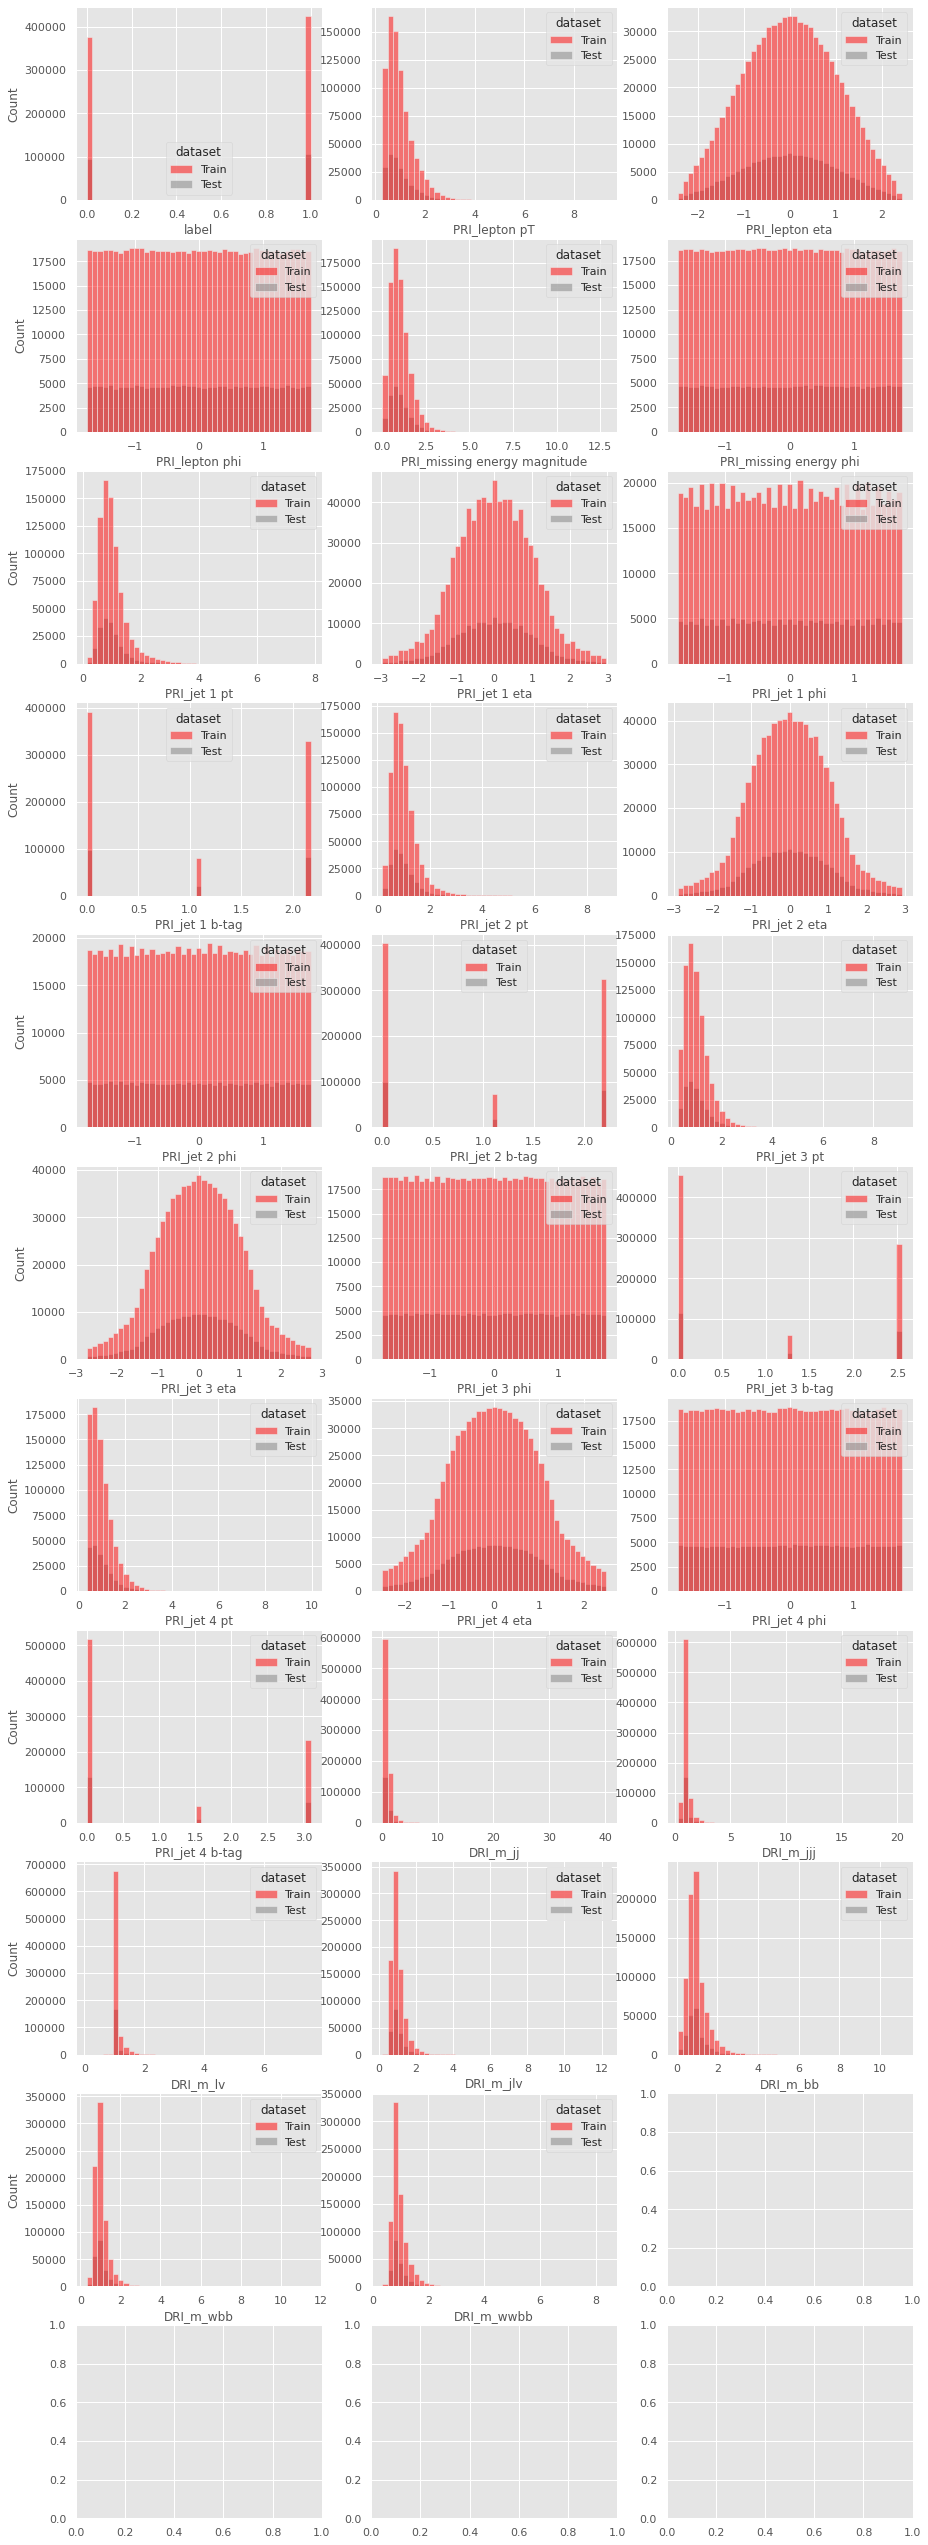

In [ ]:
# Distributions of the float features
hist(datashow, list(sampleTest.columns),bins = (math.floor(len(sampleTrain)**(1/3))))

**Create Dense vector**


- We need to split the 'label' columns and 'features' columns made of DenseVector objects. 
- That way we can map the (float, DenseVector) objects into LabeledPoint objects which are required for the MLlib Gradient Boosted Trees and Random Forest classifiers. 

In [ ]:
training_dense  = trainData.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
training_dense = spark.createDataFrame(training_dense, ["label", "features"])

test_dense = testData.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
test_dense = spark.createDataFrame(test_dense, ["label", "features"])

**Testing out several of the machine learning methods.**  
- And defining the pipeline:  which acts as an estimator. 
- A Pipeline consists of a sequence of stages, each of which is either an Estimator or a Transformer.
- When `Pipeline.fit()` is called, the stages are executed in orde

# 1) Decision Tree Classifier


In [ ]:
def decisionTreeClassifier(trainingData, testData, ncolumns, schemaNames):

	dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")# Creating DTC Model
	
	# We use a ParamGridBuilder to construct a grid of parameters to search over.
	paramGrid = ParamGridBuilder()\
	    .addGrid(dt.maxDepth, [5, 10, 15]) \
	    .addGrid(dt.maxBins, [5, 10, 15]) \
	    .addGrid(dt.impurity, ['gini','entropy'])\
	    .build()
		 
	# creating pipeline
	pipeline = Pipeline(stages=[dt]) 
 
  # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
	crossvalDT = CrossValidator(estimator=pipeline,
	                          estimatorParamMaps=paramGrid,
	                          evaluator=BinaryClassificationEvaluator(metricName='accuracy'),
	                          numFolds=5) # Number of K - Folds
	best_params = ''
	cvModelDT = crossvalDT.fit(trainingData) # Traing DTC
	prediction = cvModelDT.transform(testData) # EVALUATION OF DT with  CROSS VALID ON TEST SET

#Evaluator for Regression, which expects input columns prediction, label and an optional weight column.
	# Select (prediction, true label) and compute test error
	evaluator = BinaryClassificationEvaluator(
	    labelCol="label", predictionCol="prediction", metricName="accuracy")
	accuracy = evaluator.evaluate(prediction)

	# Evaluate model
	evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
	areaUC = evaluator.evaluate(prediction)

	bModel = cvModelDT.bestModel.stages[0]
	fi = bModel.featureImportances

	imp_feat = np.zeros(ncolumns-1)
	imp_feat[fi.indices] = fi.values
	x = np.arange(ncolumns-1)
	idx = (-imp_feat).argsort()[:3]
	feat = []
	for i in idx:    
	    feat.append(schemaNames[i])

	best_params = (cvModelDT.getEstimatorParamMaps()[ np.argmax(cvModelDT.avgMetrics) ])
	return feat, accuracy, areaUC, best_params

In [ ]:
schemaNames = short_df.schema.names
ncolumns = len(short_df.columns)
feat, accuracy, areaUC, best_params, F1= decisionTreeClassifier(training_dense, test_dense, ncolumns, schemaNames)
print('\n\n\n ----------------------------------------------------------------------------')
print('\t-------------- Results for DecisionTreeClassifier --------------\n')
print("Accuracy for DecisionTreeClassifier = %g " % (accuracy))
print("AreaUndertheCurve for DecisionTreeClassifier = %g " % areaUC)
print("The F1-Score is = %g" %F1)
print('\n Top Three Features for Decision Tree Classifier\n')
for i in range(len(feat)):
		print(i+1, ' ->' ,feat[i])

print("\nBest Params for DTC are: ", best_params)
print('\n ----------------------------------------------------------------------------\n\n')

---------------------------------------------------------------------------

 -------------- Results for DecisionTreeClassifier --------------


  Accuracy for DecisionTreeClassifier = 0.680299 

  AreaUndertheCurve for DecisionTreeClassifier = 0.678202 

  The F1-Score is = 0.672713

  Top Three Features for Decision Tree Classifier 


1  -> DRI_m_jlv 

2  -> DRI_m_wbb 

3  -> DRI_m_bb 


Best Params for DTC are:  {Param(parent='DecisionTreeClassifier_5060c9591ba9', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='DecisionTreeClassifier_5060c9591ba9', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 15, Param(parent='DecisionTreeClassifier_5060c9591ba9', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported o

# 2 Logistic Regression

In [ ]:

lr_model = LogisticRegression()
lr_pipeline = Pipeline(stages=[assembler, scaler, lr_model])
lr_model_fit = lr_model.fit(training_dense)
lr_results = lr_model_fit.transform(test_dense)
lr_evaluation = BinaryClassificationEvaluator(predictionCol="prediction")

print("Metrics for Logistic Regression model")
lr_accuracy = str(lr_evaluation.evaluate(lr_results, {lr_evaluation.metricName: "accuracy"}))
lr_f1_score = str(lr_evaluation.evaluate(lr_results, {lr_evaluation.metricName: "f1"}))
print("Accuracy: " + lr_accuracy)
print("F-1 Score: " + lr_f1_score)

Metrics for Logistic Regression model
Accuracy: 0.6419771786327375
F-1 Score: 0.6373966177931808


# 3 Random Forest Classifier

In [ ]:

RF_model = RandomForestClassifier()
RF_pipeline = Pipeline(stages=[assembler, scaler, RF_model])
RF_model_fit = RF_model.fit(training_dense)
RF_results = RF_model_fit.transform(test_dense)
RF_evaluation = BinaryClassificationEvaluator(predictionCol="prediction")

print("Metrics for RF Classifier model")
RF_accuracy = str(RF_evaluation.evaluate(RF_results, {RF_evaluation.metricName: "accuracy"}))
RF_f1_score = str(RF_evaluation.evaluate(RF_results, {RF_evaluation.metricName: "f1"}))
print("Accuracy: " + RF_accuracy)
print("F-1 Score: " + RF_f1_score)

Metrics for RF Classifier model
Accuracy: 0.6761587397758255
F-1 Score: 0.6728346256101143


# 4 Support Vector machines

In [ ]:
LSVM_model = LinearSVC()
LSVM_pipeline = Pipeline(stages=[assembler, scaler, LSVM_model])
LSVM_model_fit = LSVM_model.fit(training_dense)
LSVM_results = LSVM_model_fit.transform(test_dense)
LSVM_evaluation = BinaryClassificationEvaluator(predictionCol="prediction")

print("Metrics for LSVM Classifier model")
LSVM_accuracy = str(LSVM_evaluation.evaluate(LSVM_results, {LSVM_evaluation.metricName: "accuracy"}))
LSVM_f1_score = str(LSVM_evaluation.evaluate(LSVM_results, {LSVM_evaluation.metricName: "f1"}))
print("Accuracy: " + LSVM_accuracy)
print("F-1 Score: " + LSVM_f1_score)

Metrics for RF Classifier model
Accuracy: 0.6418761991315763
F-1 Score: 0.6268684304357199


# 5 Gradient Boosted Trees

In [ ]:
gbt_model = GBTClassifier()
gbt_pipeline = Pipeline(stages=[assembler, scaler, gbt_model])
gbt_model_fit = gbt_model.fit(training_dense)
gbt_results = gbt_model_fit.transform(test_dense)
gbt_evaluation = BinaryClassificationEvaluator(predictionCol="prediction")

print("Metrics for GBT Classifier model")
gbt_accuracy = str(gbt_evaluation.evaluate(gbt_results, {gbt_evaluation.metricName: "accuracy"}))
gbt_f1_score = str(gbt_evaluation.evaluate(gbt_results, {gbt_evaluation.metricName: "f1"}))
print("Accuracy: " + gbt_accuracy)
print("F-1 Score: " + gbt_f1_score)

Metrics for GBT Classifier model
Accuracy: 0.7041300615974957
F-1 Score: 0.7040909385760101


In [ ]:
# Combine my model results into one dataframe
model_names = ['Logistic Regression Model', 'GBT Classifer Model' ,"Random forest model" ,"Linear Support Vector Model" ]
model_accuracies = [lr_accuracy, gbt_accuracy, RF_accuracy, LSVM_accuracy ]
model_f1_scores = [lr_f1_score, gbt_f1_score, RF_f1_score, LSVM_f1_score  ]
model_results_df = pd.DataFrame(list(zip(model_accuracies,model_f1_scores)), index=model_names, columns=['Accuracy','F1_Score'])
model_results_df.head()

,Accuracy,F1_Score
Logistic Regression Model,0.6419771786327375,0.6373966177931808
GBT Classifer Model,0.7041300615974957,0.7040909385760101
Random forest model,0.6761587397758255,0.6728346256101143
Linear Support Vector Model,0.6418761991315763,0.6268684304357199


# Gradient Boosted Tree Classifier seems to be the winner model so lets do crossvalidation and find the best model.

In [ ]:
train_start = time.time()

gbt_param_grid = ParamGridBuilder().addGrid(gbt_model.maxIter, [5,10,20]).addGrid(gbt_model.maxDepth, [3]).addGrid(gbt_model.minInfoGain, [0]).addGrid(gbt_model.minInstancesPerNode, [1]).build()
gbt_cross_val = CrossValidator(estimator=gbt_model, estimatorParamMaps=gbt_param_grid, evaluator=BinaryClassificationEvaluator(metricName='f1'))
gbt_cross_val_model = gbt_cross_val.fit(training_dense)
gbt_tuned_results = gbt_cross_val_model.bestModel.transform(test_dense)
gbt_tuned_evaluation = BinaryClassificationEvaluator(predictionCol="prediction")

print("Metrics for Tuned GBT Classifier Model")
gbt_tuned_accuracy = str(gbt_tuned_evaluation.evaluate(gbt_tuned_results, {gbt_tuned_evaluation.metricName: "accuracy"}))
gbt_tuned_f1_score = str(gbt_tuned_evaluation.evaluate(gbt_tuned_results, {gbt_tuned_evaluation.metricName: "f1"}))
print("Accuracy: " + gbt_tuned_accuracy)
print("F-1 Score: " + gbt_tuned_f1_score)  
train_end = time.time()
print(f'Time elapsed training model: {train_end - train_start} seconds')

Metrics for Tuned GBT Classifier Model
Accuracy: 0.6872664849035646
F-1 Score: 0.6868134948891119
Time elapsed training model: 185.34374332427979 seconds


**Show the parameters that were part of the best model**

In [ ]:
gbt_cross_val_model.bestModel.extractParamMap()

{Param(parent='GBTClassifier_7d02927d0b5b', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_7d02927d0b5b', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_7d02927d0b5b', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

In [ ]:
gbt_tuned_evaluation.metricName

 Param(parent='BinaryClassificationEvaluator_f6a8a17ab1ba', name='metricName', doc='metric name in evaluation 

(f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel|

falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss)')


**Checking True Positive Rate by Label.**

In [ ]:
str(gbt_tuned_evaluation.evaluate(gbt_tuned_results, {gbt_tuned_evaluation.metricName: "truePositiveRateByLabel"}))

'0.6486544211875267'

**PREDICTING LABELS**

In [ ]:
labels=gbt_tuned_results.toPandas()['label']
labels

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
19801    1.0
19802    1.0
19803    1.0
19804    1.0
19805    1.0
Name: label, Length: 19806, dtype: float64

**Drawing ROC curve for Gradient Boosted Tree Classifier**

<Figure size 432x288 with 0 Axes>

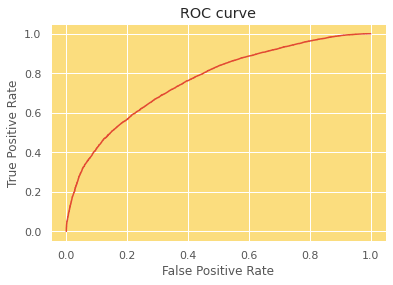

In [ ]:
from sklearn.metrics import roc_curve
def roc(ax, predictions, labels, title='ROC curve'):
    ''' outputs the roc curve on ax axes'''
    prediction_prob = predictions.toPandas()['probability'].apply(lambda x:x[1]).values
    fpr, tpr, _ = roc_curve(labels, prediction_prob)
    ax.plot(fpr, tpr)
    ax.set_facecolor('xkcd:wheat')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
   

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
roc(ax, gbt_tuned_results,labels)

**Drawing the precision recall curve for Gradient Boosted Tree Classifier**

In [ ]:
from sklearn.metrics import precision_recall_curve
def pr(ax, predictions, labels, title='Precision-Recall curve'):
    ''' outputs the roc curve on ax axes'''
    prediction_prob = predictions.toPandas()['probability'].apply(lambda x:x[1]).values
    pr, rc, _ = precision_recall_curve(labels, prediction_prob)
    ax.plot(pr, rc)
    ax.set_facecolor('xkcd:wheat')
    ax.set_xlabel('Recall Rate')
    ax.set_ylabel('Precision Rate')
    ax.set_title(title)

<Figure size 432x288 with 0 Axes>

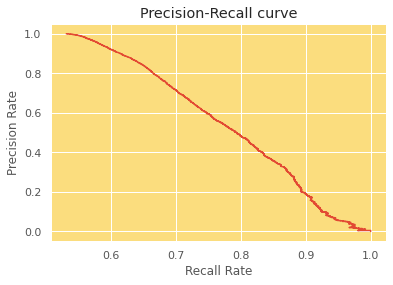

In [ ]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
pr(ax,gbt_tuned_results ,labels)

**DRAWING ROC CURVE OF LOGISTIC REGRESSION**

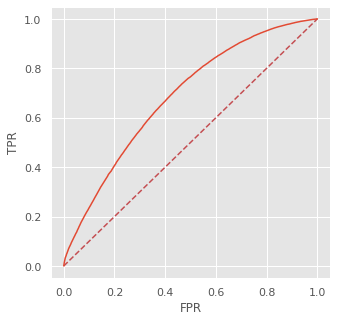

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lr_model_fit.summary.roc.select('FPR').collect(),
         lr_model_fit.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

**DRAWING ROC CURVE FOR RANDOM FOREST**

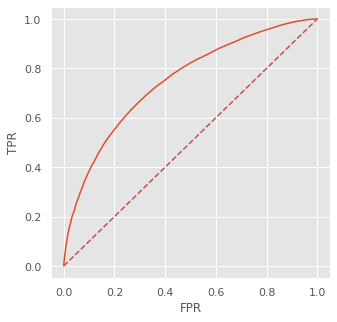

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(RF_model_fit.summary.roc.select('FPR').collect(),
         RF_model_fit.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# END